# 03 — Evaluation & Benchmarks (Early Credit Warning)

This notebook evaluates baseline early credit risk models and adds a benchmark model
(Random Forest) for comparison.

Governance rules:
- No changes to preprocessing decisions from Notebook 02
- Baseline models are loaded and evaluated unchanged
- Benchmark model is trained using the same governed train/test split
- Results emphasize early warning trade-offs (recall/precision, thresholds), not accuracy alone


#### Imports & paths

In [19]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix
)

import joblib

In [20]:
NOTEBOOK_DIR = Path("/Users/steph/Desktop/Github/early-warning-credit-risk/02_notebooks")
PROJECT_ROOT = NOTEBOOK_DIR.parent

IN_DIR = PROJECT_ROOT / "03_artifacts" / "notebook02"
OUT_DIR = PROJECT_ROOT / "03_artifacts" / "notebook03"
OUT_DIR.mkdir(parents=True, exist_ok=True)


#### Load artifacts

In [21]:
# Predictions saved in Notebook 02
train_preds = pd.read_csv(IN_DIR / "train_predictions.csv", index_col=0)
test_preds  = pd.read_csv(IN_DIR / "test_predictions.csv", index_col=0)

# Splits saved in Notebook 02 (for benchmark training)
X_train = pd.read_csv(IN_DIR / "X_train.csv", index_col=0)
X_test  = pd.read_csv(IN_DIR / "X_test.csv", index_col=0)
y_train = pd.read_csv(IN_DIR / "y_train.csv", index_col=0).squeeze("columns")
y_test  = pd.read_csv(IN_DIR / "y_test.csv", index_col=0).squeeze("columns")

# Load fitted baseline pipelines
pipe_log = joblib.load(IN_DIR / "pipeline_logistic.joblib")
pipe_l1  = joblib.load(IN_DIR / "pipeline_l1_logistic.joblib")

print("Train preds:", train_preds.shape, "Test preds:", test_preds.shape)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Bad rate test:", round(y_test.mean(), 4))


Train preds: (800, 3) Test preds: (200, 3)
X_train: (800, 20) X_test: (200, 20)
Bad rate test: 0.3


## Evaluation metrics

We report:
- ROC-AUC (ranking performance)
- Average Precision / PR-AUC (more informative under imbalance)
- Confusion matrix at selected thresholds

Early warning emphasis:
- We will compare recall/precision trade-offs.
- Threshold selection is treated as a governance decision (cost of false positives vs false negatives).


#### Metric helpers

In [22]:
def summarize_metrics(y_true, p):
    return {
        "ROC_AUC": roc_auc_score(y_true, p),
        "PR_AUC": average_precision_score(y_true, p),
    }

def confusion_at_threshold(y_true, p, threshold=0.5):
    y_hat = (p >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_hat)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0
    fpr       = fp / (fp + tn) if (fp + tn) else 0.0

    return {
        "threshold": threshold,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "precision": precision,
        "recall": recall,
        "fpr": fpr
    }


####  Baseline evaluation (test)

In [23]:
p_log_test = test_preds["p_logistic"].values
p_l1_test  = test_preds["p_l1_logistic"].values

baseline_metrics = pd.DataFrame([
    {"model": "Logistic", **summarize_metrics(y_test, p_log_test)},
    {"model": "L1 Logistic", **summarize_metrics(y_test, p_l1_test)},
]).sort_values("ROC_AUC", ascending=False)

baseline_metrics


,model,ROC_AUC,PR_AUC
1,L1 Logistic,0.783333,0.616149
0,Logistic,0.776429,0.606820


## Curves (ROC and Precision–Recall)

ROC curves can look optimistic under imbalance, so PR curves are included.


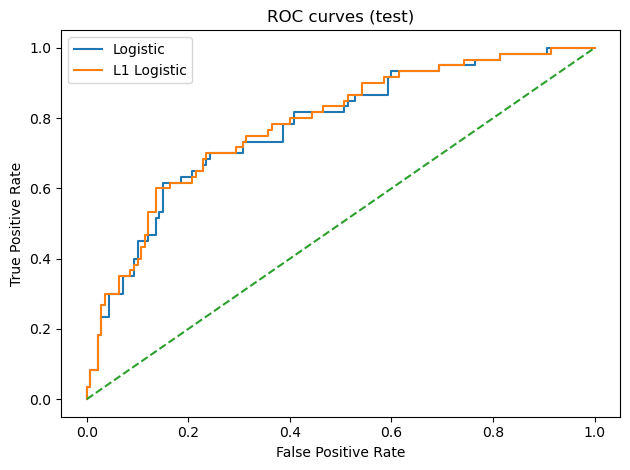

In [24]:
# ROC curves
plt.figure()
for name, p in [("Logistic", p_log_test), ("L1 Logistic", p_l1_test)]:
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC curves (test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.tight_layout()
plt.savefig("modeling_and_validation_ROC_curves_test.png", dpi=300, bbox_inches="tight")
plt.show()


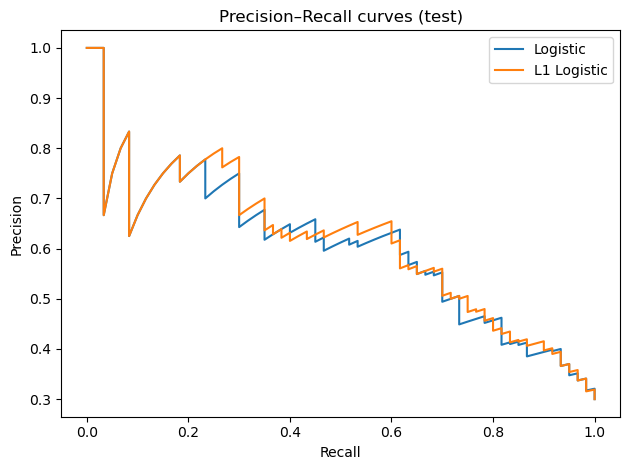

In [25]:
# PR curves
plt.figure()
for name, p in [("Logistic", p_log_test), ("L1 Logistic", p_l1_test)]:
    prec, rec, _ = precision_recall_curve(y_test, p)
    plt.plot(rec, prec, label=name)
plt.title("Precision–Recall curves (test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.savefig("modeling_and_validation_precision_recall_curves_test.png", dpi=300, bbox_inches="tight")
plt.show()


## Threshold selection 

A common early warning approach is to choose a threshold based on:
- acceptable false positive rate (FPR), or
- operational review capacity (e.g., flag top X% of accounts).

Below we compute recall at a few candidate thresholds.


#### Threshold table

In [26]:
thresholds = [0.05, 0.10, 0.20, 0.30, 0.50]

rows = []
for t in thresholds:
    rows.append({"model": "Logistic", **confusion_at_threshold(y_test, p_log_test, t)})
    rows.append({"model": "L1 Logistic", **confusion_at_threshold(y_test, p_l1_test, t)})

threshold_table = pd.DataFrame(rows)
threshold_table[["model","threshold","precision","recall","fpr","tp","fp","fn","tn"]]


,model,threshold,precision,recall,fpr,tp,fp,fn,tn
0,Logistic,0.05,0.339181,0.966667,0.807143,58,113,2,27
1,L1 Logistic,0.05,0.339080,0.983333,0.821429,59,115,1,25
2,Logistic,0.10,0.391608,0.933333,0.621429,56,87,4,53
3,L1 Logistic,0.10,0.380952,0.933333,0.650000,56,91,4,49
4,Logistic,0.20,0.457143,0.800000,0.407143,48,57,12,83
5,L1 Logistic,0.20,0.456311,0.783333,0.400000,47,56,13,84
6,Logistic,0.30,0.545455,0.700000,0.250000,42,35,18,105
7,L1 Logistic,0.30,0.525000,0.700000,0.271429,42,38,18,102
8,Logistic,0.50,0.603774,0.533333,0.150000,32,21,28,119
9,L1 Logistic,0.50,0.648148,0.583333,0.135714,35,19,25,121


### Benchmark model: Random Forest

Random Forest is used as a performance benchmark, not as a default deployment choice.

It may outperform baselines on ranking metrics but typically reduces transparency.
This is why it is evaluated in Notebook 03 and not used to define preprocessing rules.


#### Train benchmark (Random Forest) using the SAME split

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Use the baseline preprocessing from the fitted logistic pipeline
# to ensure identical transformations.

preprocess_fitted = pipe_log.named_steps["preprocess"]

Xt_train = preprocess_fitted.transform(X_train)
Xt_test  = preprocess_fitted.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(Xt_train, y_train)
p_rf_test = rf.predict_proba(Xt_test)[:, 1]

print("RF fitted.")


RF fitted.


#### Compare baseline vs benchmark

In [28]:
all_metrics = pd.DataFrame([
    {"model": "Logistic", **summarize_metrics(y_test, p_log_test)},
    {"model": "L1 Logistic", **summarize_metrics(y_test, p_l1_test)},
    {"model": "Random Forest (benchmark)", **summarize_metrics(y_test, p_rf_test)},
]).sort_values("PR_AUC", ascending=False)

all_metrics


,model,ROC_AUC,PR_AUC
2,Random Forest (benchmark),0.819762,0.704557
1,L1 Logistic,0.783333,0.616149
0,Logistic,0.776429,0.606820


#### Curves including RF

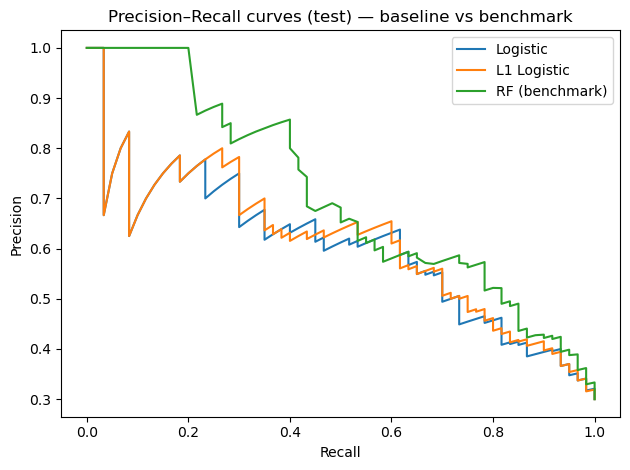

In [29]:
plt.figure()
for name, p in [("Logistic", p_log_test), ("L1 Logistic", p_l1_test), ("RF (benchmark)", p_rf_test)]:
    prec, rec, _ = precision_recall_curve(y_test, p)
    plt.plot(rec, prec, label=name)
plt.title("Precision–Recall curves (test) — baseline vs benchmark")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.savefig("modeling_and_validation_Precision_Recall_curves_test_baseline_vs_benchmark.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
# Outputs

baseline_metrics.to_csv(OUT_DIR / "baseline_metrics.csv", index=False)
all_metrics.to_csv(OUT_DIR / "all_model_metrics.csv", index=False)
threshold_table.to_csv(OUT_DIR / "threshold_table.csv", index=False)

rf_out = pd.DataFrame({"y": y_test.values, "p_rf_test": p_rf_test}, index=X_test.index)
rf_out.to_csv(OUT_DIR / "rf_test_predictions.csv", index=True)

joblib.dump(rf, OUT_DIR / "rf_benchmark.joblib")

meta = {
    "notebook": "03_evaluation_benchmarks.ipynb",
    "notes": "Evaluates baselines and trains Random Forest benchmark using identical governed preprocessing and split.",
    "files_read": [
        "notebook02/train_predictions.csv",
        "notebook02/test_predictions.csv",
        "notebook02/X_train.csv",
        "notebook02/X_test.csv",
        "notebook02/y_train.csv",
        "notebook02/y_test.csv",
        "notebook02/pipeline_logistic.joblib",
        "notebook02/pipeline_l1_logistic.joblib",
    ],
    "files_written": [
        "baseline_metrics.csv",
        "all_model_metrics.csv",
        "threshold_table.csv",
        "rf_test_predictions.csv",
        "rf_benchmark.joblib",
    ]
}

with open(OUT_DIR / "run_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

